<a href="https://colab.research.google.com/github/ewankim1023/KagglePlayground/blob/main/Surface_Crack_Outlier_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Download Dataset

https://www.kaggle.com/arunrk7/surface-crack-detection

In [ ]:
# Latent vector 

# input image 에서 encoding하고 나면 Latent vector가 나오는데 해당 Latent vector를 decoding해서 다시 input 사이즈 만큼의 사이즈로 변화하는 것.

# Original - Reconstruction --> Outlier score channel 0,1,2
# auto encoder model

# https://www.youtube.com/watch?v=RJ4oB6MWTsA&t=4s

In [ ]:
import os
os.environ['KAGGLE_USERNAME'] = 'ewankim1023' # username
os.environ['KAGGLE_KEY'] = '853708878afa5ae0318c9a654235cfa7' # key

In [ ]:
#download dataset
!kaggle datasets download -d arunrk7/surface-crack-detection

 96% 224M/233M [00:01<00:00, 120MB/s]
100% 233M/233M [00:02<00:00, 119MB/s]


In [ ]:
#unzip 
!unzip -q surface-crack-detection.zip

# Install alibi_detect

In [ ]:
!pip install alibi_detect

# Import Packages

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, Dense, Layer, Reshape, InputLayer
# from alibi_detect.models.losses import elbo
from alibi_detect.od import OutlierVAE
from alibi_detect.utils.visualize import plot_instance_score, plot_feature_outlier_image
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from glob import glob

# Load Normal Images

- Negative: normal images
- Positive: crack images

In [ ]:
img_list = glob('Negative/*.jpg') # grabbing images with Glob

train_img_list, val_img_list = train_test_split(img_list, test_size=0.1, random_state=2021) # divide two indices train and val

def img_to_np(fpaths, resize=True): # file 경로  
    img_array = []
    for fname in fpaths: #
      try:
        img = Image.open(fname).convert('RGB') # RGB convert
        if(resize): img = img.resize((64, 64)) #resize
        img_array.append(np.asarray(img)) # 
      except:
        continue
    images = np.array(img_array)
    return images

x_train = img_to_np(train_img_list[:1000]) # example for 1000
x_train = x_train.astype(np.float32) / 255. # Normalisation

x_val = img_to_np(val_img_list[:32]) # 32 images for sample
x_val = x_val.astype(np.float32) / 255.

print(x_train.shape)
print(x_val.shape)

(1000, 64, 64, 3)
(32, 64, 64, 3)


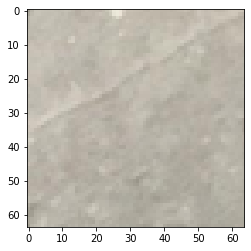

In [ ]:
plt.imshow(x_train[2]) #training noraml image for training

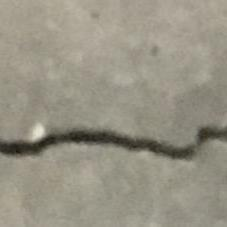

In [ ]:
import glob
import random
from IPython.display import Image, clear_output

image_name = random.choice(glob.glob('Positive/*.jpg'))
display(Image(filename=image_name))

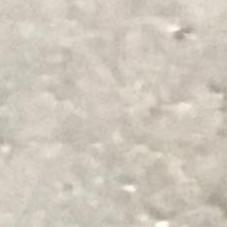

In [ ]:
image_name = random.choice(glob.glob('Negative/*.jpg'))
display(Image(filename=image_name))

# Build Model

In [ ]:
'''torch.nn.Conv2d(
    in_channels, # compulsory
    out_channels, # compulsory
    kernel_size, # compulsory
    stride=1, 
    padding=0, 
    dilation=1, 
    groups=1, 
    bias=True, 
    padding_mode='zeros'
)'''

"torch.nn.Conv2d(\n    in_channels, # compulsory\n    out_channels, # compulsory\n    kernel_size, # compulsory\n    stride=1, \n    padding=0, \n    dilation=1, \n    groups=1, \n    bias=True, \n    padding_mode='zeros'\n)"

In [ ]:
latent_dim = 512
# Simple model

encoder_net = tf.keras.Sequential([ #Keras basic 
    InputLayer(input_shape=(64, 64, 3)), # inputsize 64 x 64 channel 3
    Conv2D(64, 4, strides=2, padding='same', activation=tf.nn.relu), #pytorch - torch.nn.Conv2D
    Conv2D(128, 4, strides=2, padding='same', activation=tf.nn.relu),
    Conv2D(512, 4, strides=2, padding='same', activation=tf.nn.relu)
])

#### latent vector 1024

decoder_net = tf.keras.Sequential([
    InputLayer(input_shape=(latent_dim,)),  #Input is latent vector 1024
    Dense(4 * 4 * 128), # Dense # 2048
    Reshape(target_shape=(4, 4, 128)),  # Transpose convolution - reshape 3D 
    Conv2DTranspose(256, 4, strides=2, padding='same', activation=tf.nn.relu),  #deconvolution, 2 times lagers than pervious input because strides is 2
    Conv2DTranspose(64, 4, strides=2, padding='same', activation=tf.nn.relu),
    Conv2DTranspose(32, 4, strides=2, padding='same', activation=tf.nn.relu),
    Conv2DTranspose(3, 4, strides=2, padding='same', activation='sigmoid')
])

od = OutlierVAE(                 # Outlier Variation Auto Encoder
    threshold=.005, # instance score 0.005 normal/abnormal
    score_type='mse', # Mean Sqaured Error
    encoder_net=encoder_net,
    decoder_net=decoder_net,
    latent_dim=latent_dim,
)

# Train

In [ ]:
od.fit(
    x_train,
    epochs=30,
    verbose=True
)

16/16 [=] - 2s 105ms/step - loss_ma: -21472.7854


# Reconstruct Training Image

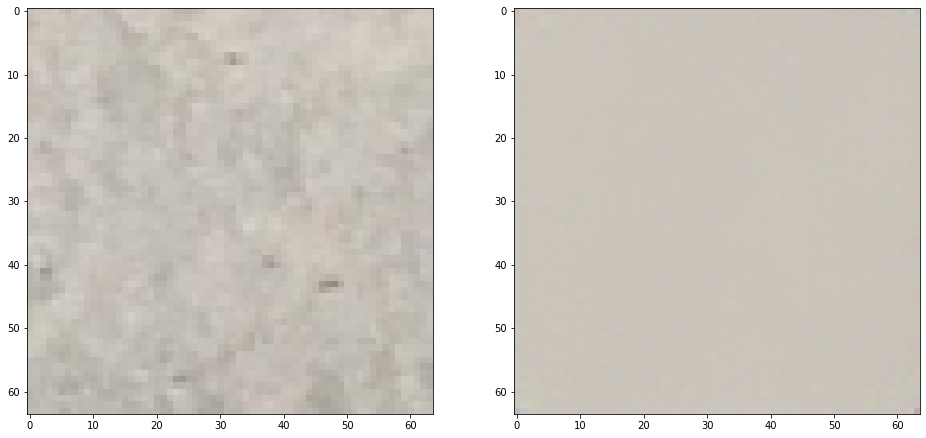

In [ ]:
idx = 12
x = x_train[idx].reshape(1, 64, 64, 3)
x_recon = od.vae(x).numpy()

fig, axes = plt.subplots(1, 2, figsize=(16, 10))

axes[0].imshow(x.squeeze())
axes[1].imshow(x_recon.squeeze())

# Validation

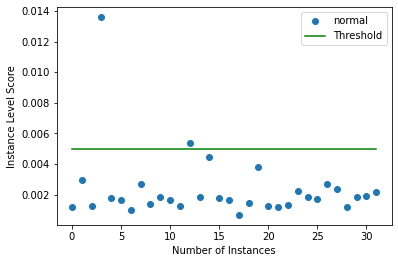

In [ ]:
od_preds = od.predict(
    x_val,
    outlier_type='instance',
    return_feature_score=True,
    return_instance_score=True
)

target = np.zeros(x_val.shape[0],).astype(int)
labels = ['normal', 'outlier']
plot_instance_score(od_preds, target, labels, od.threshold)

# Reconstruct Validation Images

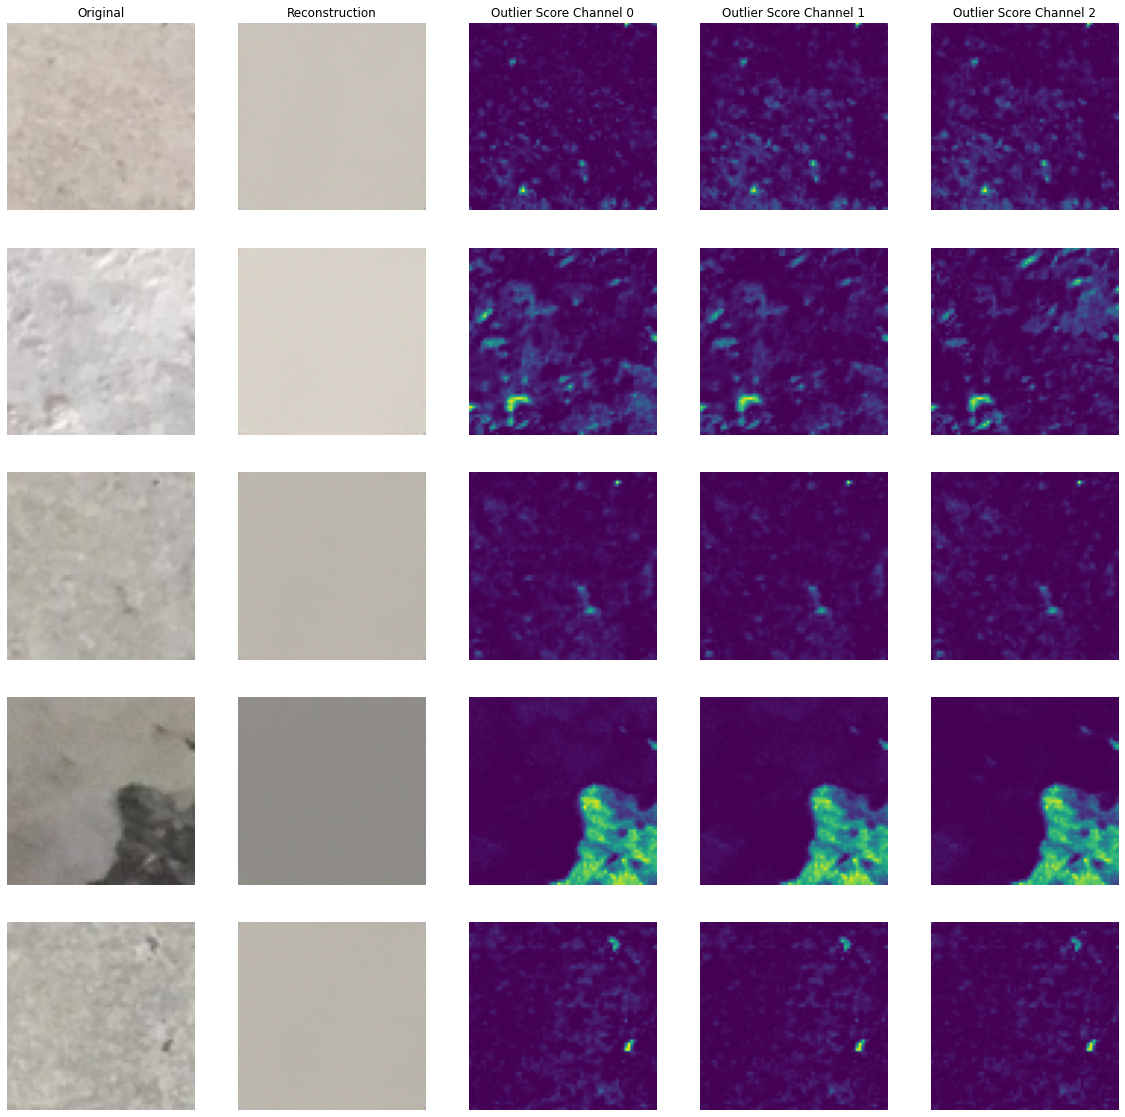

In [ ]:
x_recon = od.vae(x_val).numpy()

plot_feature_outlier_image(
    od_preds,
    x_val,
    X_recon=x_recon,
    max_instances=5,
    outliers_only=False
)

# Outliers

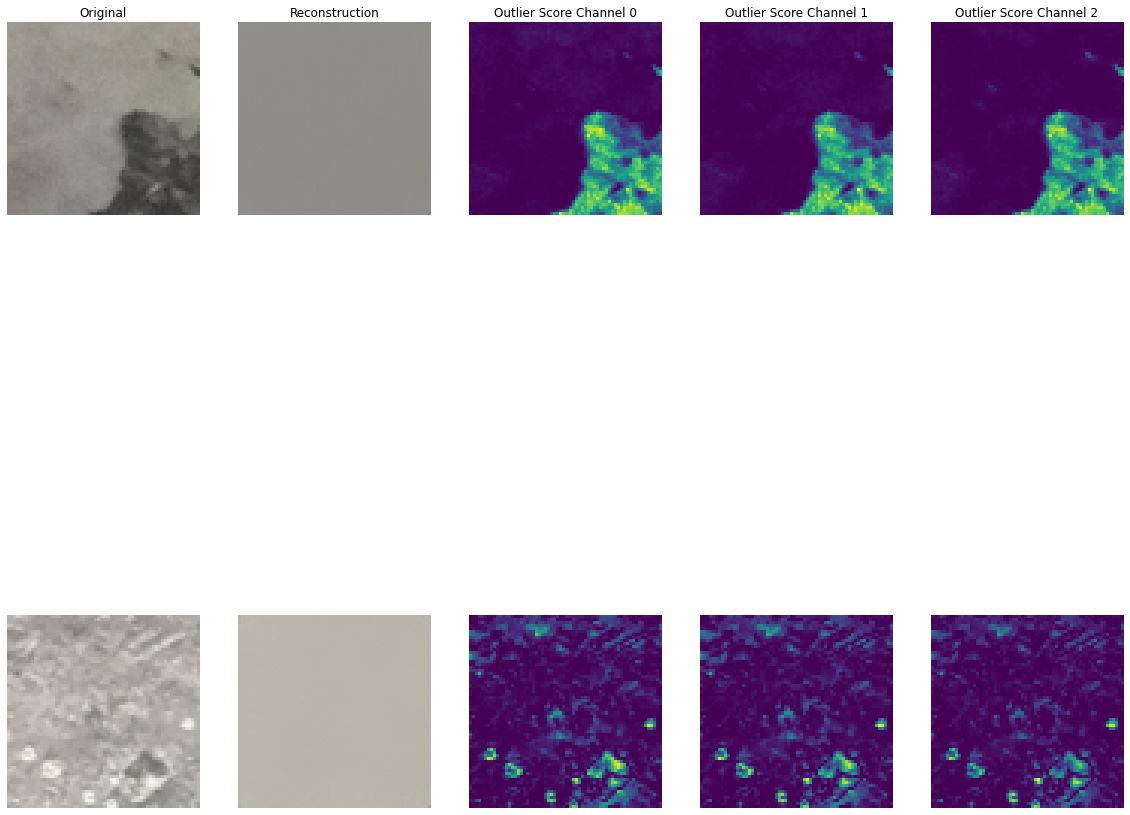

In [ ]:
plot_feature_outlier_image(
    od_preds,
    x_val,
    X_recon=x_recon,
    max_instances=5,
    outliers_only=True
)

# Test with Crack Images

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, Dense, Layer, Reshape, InputLayer
# from alibi_detect.models.losses import elbo
from alibi_detect.od import OutlierVAE
from alibi_detect.utils.visualize import plot_instance_score, plot_feature_outlier_image
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from glob import glob

In [ ]:
test_img_list = glob('Positive/*.jpg')

x_test = img_to_np(test_img_list[:32])
x_test = x_test.astype(np.float32) / 255.

print(x_test.shape)

(32, 64, 64, 3)


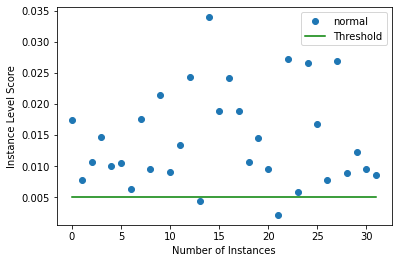

In [ ]:
od_preds = od.predict(
    x_test,
    outlier_type='instance',
    return_feature_score=True,
    return_instance_score=True
)

target = np.zeros(x_test.shape[0],).astype(int)
labels = ['normal', 'outlier']
plot_instance_score(od_preds, target, labels, od.threshold)

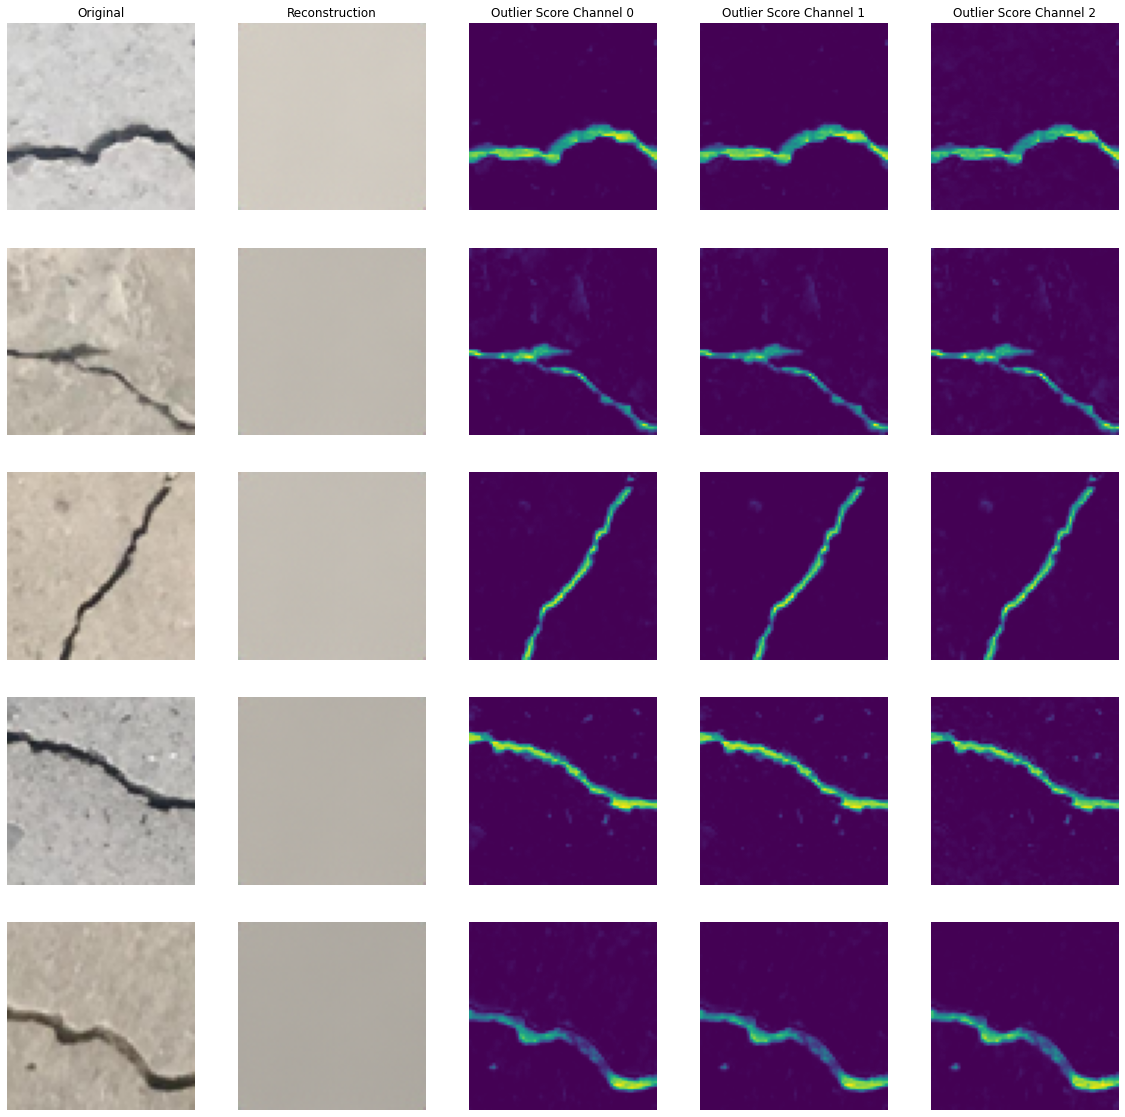

In [ ]:
x_recon = od.vae(x_test).numpy()

plot_feature_outlier_image(
    od_preds,
    x_test,
    X_recon=x_recon,
    max_instances=5,
    outliers_only=False
)